# Configurações Iniciais

In [1]:
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split, Dataset, Subset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
import numpy as np
from torchvision import models
import random
import torch
from collections import Counter
from torchvision.utils import make_grid

import os

def set_seed(seed=1234):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("device:", device)
print("cuda disponível?", torch.cuda.is_available())

device: cuda:0
cuda disponível? True


# Preparação do Dataset

In [2]:
import kagglehub

path = kagglehub.dataset_download("samithsachidanandan/human-face-emotions")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'human-face-emotions' dataset.
Path to dataset files: /kaggle/input/human-face-emotions


In [3]:
data_root = os.path.join(path, "Data")
base_dataset = datasets.ImageFolder(data_root)

print("Classes encontradas:", base_dataset.classes)

Classes encontradas: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


In [4]:
img_size = (224, 224)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply(
        [transforms.RandomRotation(5)],
        p=0.5
    ),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

In [5]:
# split treino/validação/teste
torch.manual_seed(42)

total_len = len(base_dataset)

test_size = int(0.2 * total_len)
train_val_size = total_len - test_size

train_val_subset, test_subset = random_split(
    base_dataset,
    [train_val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

val_ratio = 0.2
val_size  = int(val_ratio * train_val_size)
train_size = train_val_size - val_size

train_subset, val_subset = random_split(
    train_val_subset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(123)
)

print(f"Tamanho treino (full): {len(train_subset)}")
print(f"Tamanho validação (full): {len(val_subset)}")
print(f"Tamanho teste (full): {len(test_subset)}")

print("\nÍndice -> nome da classe:")
for idx, name in enumerate(base_dataset.classes):
    print(idx, "->", name)

Tamanho treino (full): 37824
Tamanho validação (full): 9456
Tamanho teste (full): 11819

Índice -> nome da classe:
0 -> Angry
1 -> Fear
2 -> Happy
3 -> Sad
4 -> Suprise


In [6]:
from collections import Counter
from torch.utils.data import Subset

MAX_TRAIN = 5000
MAX_VAL   = 3000
MAX_TEST  = 3000

max_train = min(MAX_TRAIN, len(train_subset))
max_val   = min(MAX_VAL,   len(val_subset))
max_test  = min(MAX_TEST,  len(test_subset))

torch.manual_seed(123)

train_idx = torch.randperm(len(train_subset))[:max_train]
val_idx   = torch.randperm(len(val_subset))[:max_val]
test_idx  = torch.randperm(len(test_subset))[:max_test]

train_subset_debug = Subset(train_subset, train_idx)
val_subset_debug   = Subset(val_subset,   val_idx)
test_subset_debug  = Subset(test_subset,  test_idx)

print(f"\nTamanho treino (debug): {len(train_subset_debug)}")
print(f"Tamanho validação (debug): {len(val_subset_debug)}")
print(f"Tamanho teste (debug): {len(test_subset_debug)}")

def contar_labels(subset):
    labels = []
    for i in range(len(subset)):
        _, label = subset[i]
        labels.append(label)
    return Counter(labels)

print("\nDistribuição no treino (debug):", contar_labels(train_subset_debug))
print("Distribuição na validação (debug):", contar_labels(val_subset_debug))
print("Distribuição no teste (debug):", contar_labels(test_subset_debug))


Tamanho treino (debug): 5000
Tamanho validação (debug): 3000
Tamanho teste (debug): 3000

Distribuição no treino (debug): Counter({2: 1594, 3: 1041, 1: 848, 0: 822, 4: 695})
Distribuição na validação (debug): Counter({2: 925, 3: 632, 0: 528, 1: 483, 4: 432})
Distribuição no teste (debug): Counter({2: 903, 3: 665, 0: 536, 1: 474, 4: 422})


In [7]:
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

use_debug = False

if use_debug:
    train_base = train_subset_debug
    val_base   = val_subset_debug
    test_base  = test_subset_debug
else:
    train_base = train_subset
    val_base   = val_subset
    test_base  = test_subset

train_dataset = SubsetWithTransform(train_base, transform=transform_train)
val_dataset   = SubsetWithTransform(val_base,   transform=transform_test)
test_dataset  = SubsetWithTransform(test_base,  transform=transform_test)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)
testloader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

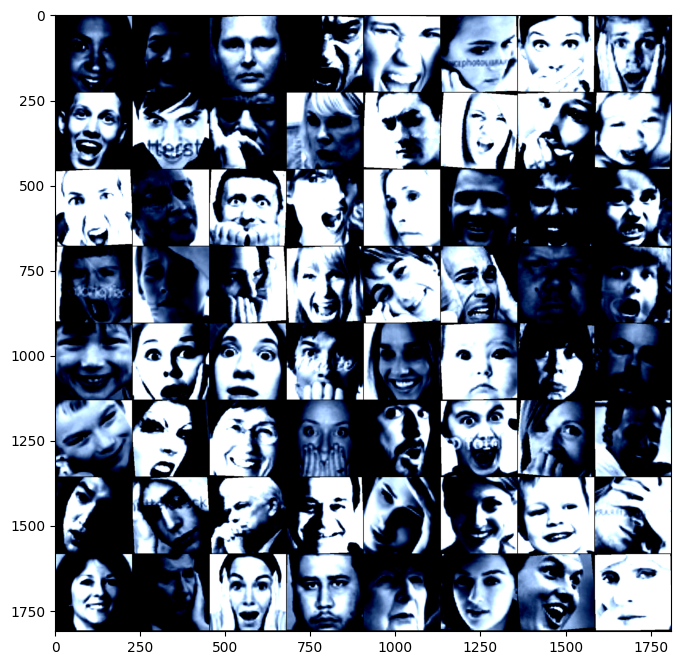

In [8]:
def imshow(img):
    plt.figure(figsize=(20,8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images = next(dataiter)
imshow(make_grid(images[0]))

# Treinando o Modelo

## Métodos Gerais: Treinamento, Validação, Acurácia, Matriz de Confusão

In [9]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(loader)

def train(model, trainloader, valloader, optimizer, criterion, epochs,
          scheduler=None, early_stopping_patience=None):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        val_loss = validation(model, valloader, criterion)

        if scheduler is not None:
            scheduler.step(val_loss)

        if early_stopping_patience is not None:
            if val_loss < best_val_loss - 1e-4:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = model.state_dict()
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    print(f"Early stopping na época {epoch + 1}. Melhor val_loss: {best_val_loss:.4f}")
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)
                    break

        current_lr = optimizer.param_groups[0]['lr']
        print(
            f'Epoch: {epoch + 1} | '
            f'Train Loss: {train_loss:.4f} | '
            f'Val Loss: {val_loss:.4f} | '
            f'LR: {current_lr:.6f}'
        )

    if early_stopping_patience is not None and best_model_state is not None:
        model.load_state_dict(best_model_state)

def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return (corrected / total) * 100

def confusion_matrix(model, loader):
    model.eval()

    class_names = base_dataset.classes
    num_classes = len(class_names)

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for true, pred in zip(labels, predicted):
                confusion_matrix[true.item(), pred.item()] += 1

    confusion_matrix = confusion_matrix.cpu().numpy()
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        confusion_matrix,
        annot=True,
        cmap='Blues',
        fmt='g',
        xticklabels=class_names,
        yticklabels=class_names
    )
    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')
    plt.title("Matriz de Confusão")
    plt.show()
    return ax


In [10]:
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


In [11]:
num_classes = len(base_dataset.classes)
in_features = resnet.fc.in_features

resnet.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes)
)

resnet = resnet.to(device)

In [12]:
for name, params in resnet.named_parameters():
    params.requires_grad = False

for name, params in resnet.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        params.requires_grad = True


In [13]:
train_labels = []
for i in range(len(train_subset)):
    _, label = train_subset[i]
    train_labels.append(label)

counts = Counter(train_labels)
print("Contagem por classe no treino (debug):", counts)

num_classes = len(base_dataset.classes)

class_weights = torch.zeros(num_classes, dtype=torch.float)
for cls in range(num_classes):
    class_weights[cls] = 1.0 / counts[cls]

class_weights = class_weights.to(device)

class_weights = class_weights / class_weights.mean()
print("Pesos por classe:", class_weights)

Contagem por classe no treino (debug): Counter({2: 11851, 3: 8058, 0: 6473, 1: 6200, 4: 5242})
Pesos por classe: tensor([1.0803, 1.1279, 0.5901, 0.8678, 1.3340], device='cuda:0')


In [14]:
resnet.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, resnet.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2
)

epochs = 20


In [15]:
train(
    resnet,
    trainloader,
    valloader,
    optimizer,
    criterion,
    epochs,
    scheduler=scheduler,
    early_stopping_patience=5
)


100%|██████████| 591/591 [04:27<00:00,  2.21it/s]


Epoch: 1 | Train Loss: 1.1046 | Val Loss: 0.8488 | LR: 0.000100


100%|██████████| 591/591 [04:24<00:00,  2.23it/s]


Epoch: 2 | Train Loss: 0.8348 | Val Loss: 0.7497 | LR: 0.000100


100%|██████████| 591/591 [04:26<00:00,  2.22it/s]


Epoch: 3 | Train Loss: 0.7038 | Val Loss: 0.6794 | LR: 0.000100


100%|██████████| 591/591 [04:28<00:00,  2.20it/s]


Epoch: 4 | Train Loss: 0.5908 | Val Loss: 0.6468 | LR: 0.000100


100%|██████████| 591/591 [04:26<00:00,  2.22it/s]


Epoch: 5 | Train Loss: 0.4897 | Val Loss: 0.5937 | LR: 0.000100


100%|██████████| 591/591 [04:26<00:00,  2.22it/s]


Epoch: 6 | Train Loss: 0.4076 | Val Loss: 0.5737 | LR: 0.000100


100%|██████████| 591/591 [04:32<00:00,  2.17it/s]


Epoch: 7 | Train Loss: 0.3443 | Val Loss: 0.6112 | LR: 0.000100


100%|██████████| 591/591 [04:31<00:00,  2.18it/s]


Epoch: 8 | Train Loss: 0.2970 | Val Loss: 0.5346 | LR: 0.000100


100%|██████████| 591/591 [04:29<00:00,  2.19it/s]


Epoch: 9 | Train Loss: 0.2543 | Val Loss: 0.5524 | LR: 0.000100


100%|██████████| 591/591 [04:27<00:00,  2.21it/s]


Epoch: 10 | Train Loss: 0.2200 | Val Loss: 0.5321 | LR: 0.000100


100%|██████████| 591/591 [04:24<00:00,  2.23it/s]


Epoch: 11 | Train Loss: 0.2009 | Val Loss: 0.5313 | LR: 0.000100


100%|██████████| 591/591 [04:27<00:00,  2.21it/s]


Epoch: 12 | Train Loss: 0.1802 | Val Loss: 0.5479 | LR: 0.000100


100%|██████████| 591/591 [04:27<00:00,  2.21it/s]


Epoch: 13 | Train Loss: 0.1663 | Val Loss: 0.5829 | LR: 0.000100


100%|██████████| 591/591 [04:25<00:00,  2.23it/s]


Epoch: 14 | Train Loss: 0.1507 | Val Loss: 0.5485 | LR: 0.000050


100%|██████████| 591/591 [04:28<00:00,  2.20it/s]


Epoch: 15 | Train Loss: 0.1105 | Val Loss: 0.5339 | LR: 0.000050


100%|██████████| 591/591 [04:26<00:00,  2.22it/s]


Early stopping na época 16. Melhor val_loss: 0.5313


# Calculando Acurácia no Conjunto de Teste

In [16]:
MODEL_PATH = "resnet18_emotions_best.pth"

torch.save(resnet.state_dict(), MODEL_PATH)
print(f"Modelo salvo em: {MODEL_PATH}")

Modelo salvo em: resnet18_emotions_best.pth


In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_classes = len(base_dataset.classes)
in_features = resnet.fc.in_features

resnet.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes)
)

MODEL_PATH = "resnet18_emotions_best.pth"
state_dict = torch.load(MODEL_PATH, map_location=device)
resnet.load_state_dict(state_dict)

resnet = resnet.to(device)
resnet.eval()

print("Modelo carregado e pronto para uso!")

Modelo carregado e pronto para uso!


A rede atinge: 89.52534055334631% de acurácia


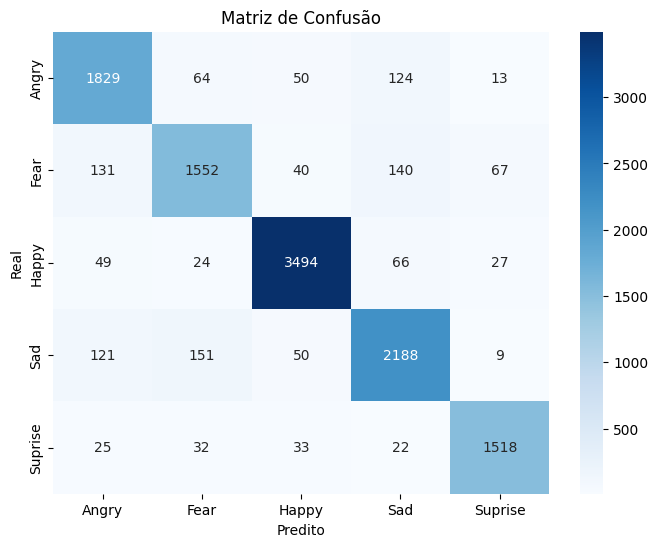

In [18]:
print(f'A rede atinge: {accuracy(resnet, testloader)}% de acurácia')
conf_mat = confusion_matrix(resnet, testloader)

# Demo

In [19]:
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

def predict_emotion(img_path, model, transform, class_names):
    model.eval()

    img = Image.open(img_path).convert("RGB")

    img_t = transform(img)
    img_t = img_t.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        probs = F.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, 1)

    predicted_class = class_names[pred_idx.item()]
    confidence = conf.item()

    return predicted_class, confidence, img

Emoção prevista: Happy (99.98% de confiança)


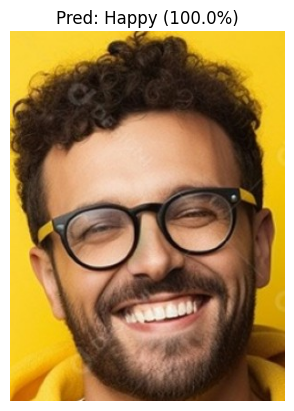

In [31]:
class_names = base_dataset.classes

img_path = "happy.jpg"

pred, conf, img = predict_emotion(img_path, resnet, transform_test, class_names)

print(f"Emoção prevista: {pred} ({conf*100:.2f}% de confiança)")

plt.imshow(img)
plt.title(f"Pred: {pred} ({conf*100:.1f}%)")
plt.axis("off")
plt.show()